# VaR & CVaR drifted Brownian Motion

In [15]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.svm import SVC
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from scipy.stats import norm
import seaborn as sns
import time
import cvxpy as cp
from scipy.optimize import minimize
import yfinance as yf
import warnings 
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [16]:
# Parameters
start_date  = '2018-01-01'
end_date    = '2023-07-30'
timeframe   = 'M'
stock_symb  = 'XOM'
rolling_p   = 6
std_mode    = 'q90'  # Options: 'mean', 'median', 'max', 'q75', 'q90'
t_ratio     = 0.6  # Drift in 5 years

num_years   = 10
num_runs    = 5000

# Fetch historical stock data
stock = yf.download(stock_symb, start=start_date, end=end_date)['Adj Close']

# Calculate daily returns
stock_last_price = float(stock[-1])
daily_returns = np.log1p(stock.pct_change())
daily_returns.name = stock_symb

# Resample the data
resampled_data = daily_returns.copy()
resampled_data.dropna(how='any', inplace=True)

if timeframe == 'W':
    resampled_data = resampled_data.resample('W').sum()
elif timeframe == 'M':
    resampled_data = resampled_data.resample('M').sum()
elif timeframe == 'Q':
    resampled_data = resampled_data.resample('Q').sum()

resampled_data.dropna(how='any', inplace=True)

# Convert the Series to a DataFrame
resampled_df = resampled_data.reset_index()
resampled_df.rename(columns={'index': 'Date', 0: stock_symb}, inplace=True)

# Calculate rolling volatility
rolling_volatility = resampled_df[stock_symb].rolling(window=rolling_p).std()

# Compute mean return and sigma based on std_mode
if std_mode == 'median':
    _rolling_volatility = rolling_volatility.median()
elif std_mode == 'mean':
    _rolling_volatility = rolling_volatility.mean()
elif std_mode == 'max':
    _rolling_volatility = rolling_volatility.max()
elif std_mode == 'q75':
    _rolling_volatility = rolling_volatility.quantile(0.75)
elif std_mode == 'q90':
    _rolling_volatility = rolling_volatility.quantile(0.90)

# Display the results
mean_return = resampled_df[stock_symb].mean()
print(f"Mean Return: {mean_return}")
print(f"Rolling Volatility ({std_mode}): {_rolling_volatility}")

[*********************100%***********************]  1 of 1 completed
Mean Return: 0.007694710267135319
Rolling Volatility (q90): 0.13716587095480312


In [17]:
def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def var_cornishfisher(r, level=5):
    """
    Returns the Parametric Gausian VaR of a Series or DataFrame
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
   
    # modify the Z score based on observed skewness and kurtosis
    s = skewness(r)
    k = kurtosis(r)
    z = (z +
            (z**2 - 1)*s/6 +
            (z**3 -3*z)*(k-3)/24 -
            (2*z**3 - 5*z)*(s**2)/36
        )
    return -(r.mean() + z*r.std(ddof=0))

Plotting...: 100%|██████████| 5000/5000 [00:01<00:00, 4128.26it/s]


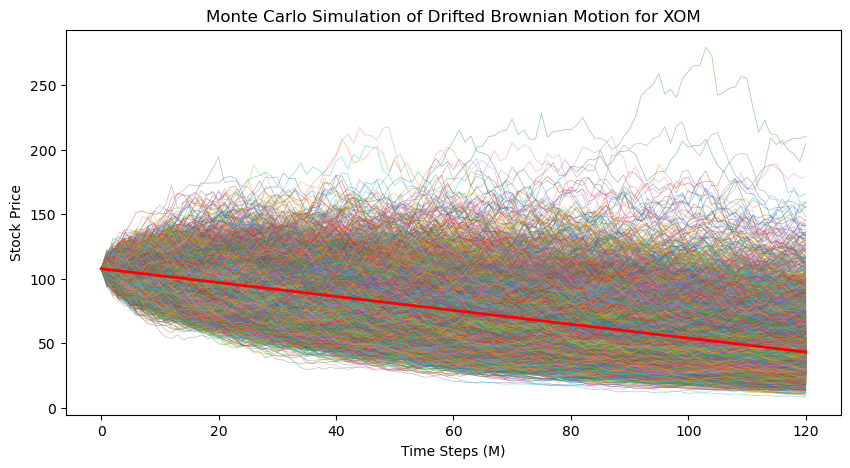

In [18]:
# Set time step and number of steps based on timeframe
if timeframe == 'D':
    dt = 1/252  # Daily time step
    num_steps = int(num_years * 252)  # Number of days in num_years
elif timeframe == 'M':
    dt = 1/12  # Monthly time step
    num_steps = int(num_years * 12)  # Number of months in num_years
elif timeframe == 'W':
    dt = 1/52
    num_steps = int(num_years * 52)  # Number of weeks in num_years

# Monte Carlo Simulation
simulations = np.zeros((num_runs, num_steps + 1))
simulations[:, 0] = stock_last_price

pbar = tqdm(total=num_runs, desc="Montecarlo", position=0, leave=True)
adjusted_t_ratio = (1+ (- 1* t_ratio))**(1/10) -1
for run in range(num_runs):
    for step in range(1, num_steps + 1):
        # Standard Brownian Motion
        Wt = np.random.normal(0, np.sqrt(dt))
        drift = (mean_return + adjusted_t_ratio) * simulations[run, step-1] * dt
        
        Xt = simulations[run, step-1] + drift + _rolling_volatility * simulations[run, step-1] * Wt
        
        # Terminate the time series if stock price goes below or equal to 0
        if Xt <= 0:
            simulations[run, step:] = np.nan  # Set the rest of the time series to NaN
            break  # Exit the inner loop
        
        # Store the result
        simulations[run, step] = Xt
        
    # Update progress bar
    pbar.update(1)

# Close progress bar
pbar.close()


# Plotting the simulations
plt.figure(figsize=(10, 5))
pbar = tqdm(total=num_runs, desc="Plotting...", position=0, leave=True)
for run in range(num_runs):
    plt.plot(simulations[run, :], alpha=0.5, linewidth=0.5)
    pbar.update(1)
pbar.close()
final_price = stock_last_price * (1 +adjusted_t_ratio)**(10)
plt.plot([0, num_steps], [stock_last_price, final_price], 'r-', linewidth=2, label='Total Drift')

plt.xlabel('Time Steps (' + timeframe + ')')
plt.ylabel('Stock Price')
plt.title(f'Monte Carlo Simulation of Drifted Brownian Motion for {stock_symb}')
plt.show()


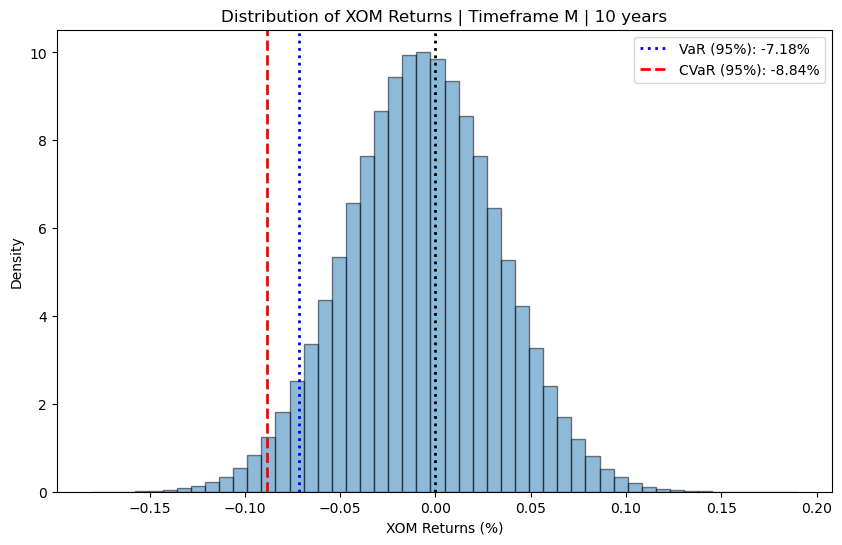

In [19]:
# Calculate the percentage returns
percentage_returns = (simulations[:, 1:] - simulations[:, :-1]) / simulations[:, :-1]
percentage_returns = percentage_returns.flatten()  # Convert to percentages

# Compute Cornish-Fisher VaR
VaR_cf = -var_cornishfisher(percentage_returns, level=5)  # Convert to percentages
CVaR = percentage_returns[percentage_returns <= VaR_cf].mean()

# Plot the distribution of returns
plt.figure(figsize=(10, 6))
plt.hist(percentage_returns, bins=50, density=True, edgecolor='k', alpha=0.5)
plt.xlabel(f'{stock_symb} Returns (%)')
plt.ylabel('Density')
plt.title(f'Distribution of {stock_symb} Returns | Timeframe {timeframe} | {num_years} years')

# Plot vertical lines for Cornish-Fisher VaR and CVaR
plt.axvline(VaR_cf, color='blue', linestyle='dotted', linewidth=2, label=f'VaR (95%): {VaR_cf*100:.2f}%')
plt.axvline(CVaR, color='red', linestyle='--', linewidth=2, label=f'CVaR (95%): {CVaR*100:.2f}%')

# Plot vertical dotted line at 0.0
plt.axvline(0.0, color='black', linestyle='dotted', linewidth=2)

# Add legend
plt.legend()

# Show the plot
plt.show()

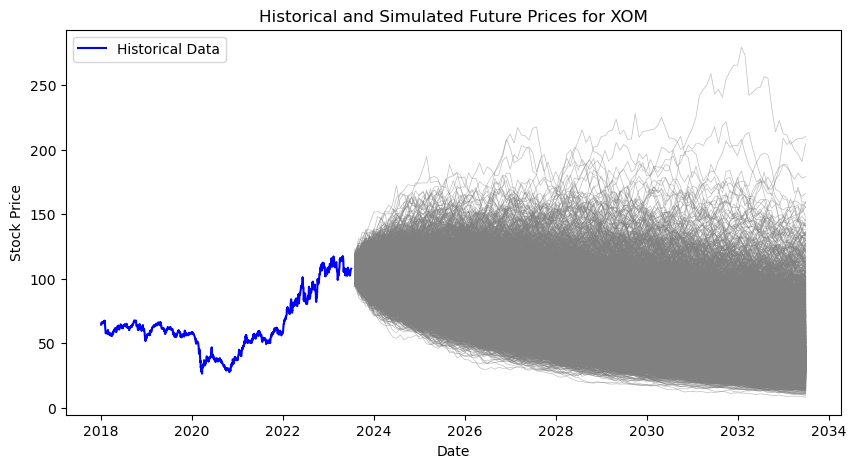

In [20]:
# Create a DataFrame for the historical data
historical_data = stock.reset_index()
historical_data.rename(columns={'index': 'Date', 'Adj Close': stock_symb}, inplace=True)

# Calculate the start date for the simulations
simulation_start_date = pd.to_datetime(end_date) + pd.DateOffset(days=1)

# Generate dates for the simulations
simulation_dates = pd.date_range(start=simulation_start_date, periods=num_steps, freq=timeframe)

# Plotting
plt.figure(figsize=(10, 5))

# Plot historical data
plt.plot(pd.to_datetime(historical_data['Date']), historical_data[stock_symb], 'b-', label='Historical Data')

# Plot simulated pathways
for run in range(num_runs):
    plt.plot(simulation_dates, simulations[run, 1:], alpha=0.5, linewidth=0.5, color='gray')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title(f'Historical and Simulated Future Prices for {stock_symb}')
plt.legend()
plt.show()


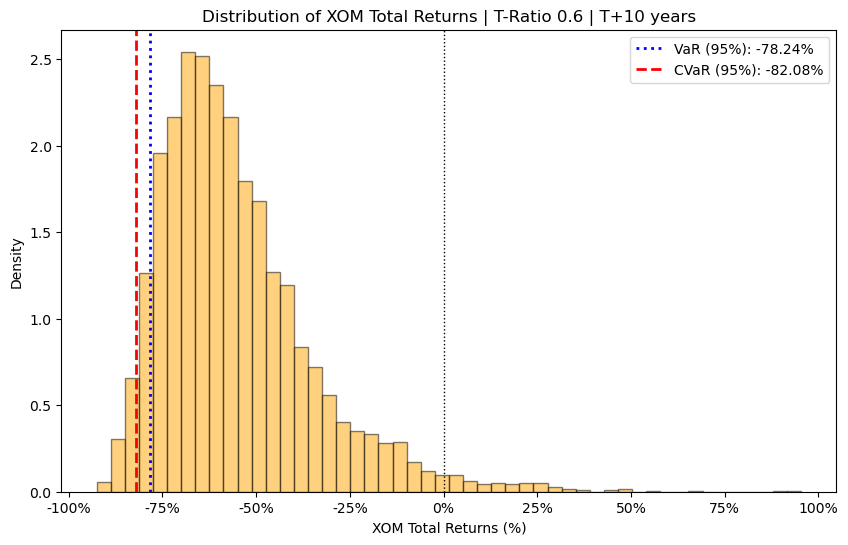

In [21]:
# Calculate the total returns
total_returns = (simulations[:, -1] - simulations[:, 0]) / simulations[:, 0]
total_returns = total_returns.flatten() 

VaR_cf = -var_cornishfisher(total_returns, level=5)  
CVaR = total_returns[total_returns <= VaR_cf].mean()

# Plot the distribution of total returns
plt.figure(figsize=(10, 6))
plt.hist(total_returns, bins=50, density=True, edgecolor='k', color='orange', alpha=0.5)  
plt.xlabel(f'{stock_symb} Total Returns (%)')
plt.ylabel('Density')
plt.title(f'Distribution of {stock_symb} Total Returns | T-Ratio {t_ratio} | T+{num_years} years')
plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
plt.axvline(VaR_cf, color='blue', linestyle='dotted', linewidth=2, label=f'VaR (95%): {VaR_cf*100:.2f}%')
plt.axvline(CVaR, color='red', linestyle='--', linewidth=2, label=f'CVaR (95%): {CVaR*100:.2f}%')
plt.axvline(0.0, color='black', linestyle='dotted', linewidth=1)
plt.legend()
plt.show()

